In [1]:
import pickle
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import sys; sys.path.append("../../..")  # Allows access to all the scripts/modules in the larger directory
from utils import calc_loadings
from sklearn.metrics import hamming_loss, accuracy_score
from collections import defaultdict
from scipy.linalg import subspace_angles

### Load consolidated decoding dataframe

In [2]:
decoding_glom_path = '/home/marcush/Data/TsaoLabData/neural_control_output/decoding_FOB_230322_214006_Jamie_param_search/decoding_FOB_230322_214006_Jamie_param_search_glom.pickle'
with open(decoding_glom_path, 'rb') as f:
    dat_decode = pickle.load(f) 

df_decode = pd.DataFrame(dat_decode)

/home/marcush/Data/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/marcush/Data/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
# Helpful ways to index / look at the df_decode
filtered_df_decode = df_decode[(df_decode['loader_args'].apply(lambda x: x.get('region')) == 'AM') & (df_decode['dimreduc_method'] == 'PCA') ]
df_decode.columns

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'predictions', 'loss',
       'decoding_object', 'Xtrain', 'Xtest', 'Ytrain', 'Ytest', 'decoder',
       'decoder_args', 'thresholds', 'data_file', 'loader', 'loader_args',
       'task_args', 'data_path', 'results_file'],
      dtype='object')

In [4]:
data_path = df_decode['data_path']

#### Load the processed data as well for other info

In [5]:
glob.glob(df_decode['data_path'][0] + "/preloaded/*.pickle")

['/home/marcush/Data/TsaoLabData/split/FOB/preloaded/preloadDict.pickle']

In [9]:
preloaded_data_path = glob.glob(df_decode['data_path'][0] + "/preloaded/preloaded_data_*.pickle")[0]
with open(preloaded_data_path, 'rb') as f:
    preload_dat = pickle.load(f) 

### Extract useful params and get average classification error 

In [10]:
degradedIDs = preload_dat['degradedIDs']
dimensions = np.unique(df_decode['dim'])
n_folds = np.unique(df_decode['fold_idx'])
regions = np.unique(df_decode['loader_args'].apply(lambda x: x.get('region')))
dimreduc_methods = np.unique(df_decode['dimreduc_method'])
stimIDs = preload_dat['StimIDs']
faceIDs = np.arange(1,17)

In [11]:
face_inds = [ID in faceIDs for ID in stimIDs]
print(f"Number of face trials: {len(stimIDs[face_inds])}, number of unique faces: {len(faceIDs)}")

Number of face trials: 118, number of unique faces: 16


In [12]:
preload_dat["StimulusNames"]

['Faces_face1.bmp',
 'Faces_face2.bmp',
 'Faces_face3.bmp',
 'Faces_face4.bmp',
 'Faces_face5.bmp',
 'Faces_face6.bmp',
 'Faces_face7.bmp',
 'Faces_face8.bmp',
 'Faces_face9.bmp',
 'Faces_face10.bmp',
 'Faces_face11.bmp',
 'Faces_face12.bmp',
 'Faces_face13.bmp',
 'Faces_face14.bmp',
 'Faces_face15.bmp',
 'Faces_face16.bmp',
 'Bodies_body1.bmp',
 'Bodies_body2.bmp',
 'Bodies_body3.bmp',
 'Bodies_body4.bmp',
 'Bodies_body5.bmp',
 'Bodies_body6.bmp',
 'Bodies_body7.bmp',
 'Bodies_body8.bmp',
 'Bodies_body9.bmp',
 'Bodies_body10.bmp',
 'Bodies_body11.bmp',
 'Bodies_body12.bmp',
 'Bodies_body13.bmp',
 'Bodies_body14.bmp',
 'Bodies_body15.bmp',
 'Bodies_body16.bmp',
 'Fruits_fruit1.bmp',
 'Fruits_fruit2.bmp',
 'Fruits_fruit3.bmp',
 'Fruits_fruit4.bmp',
 'Fruits_fruit5.bmp',
 'Fruits_fruit6.bmp',
 'Fruits_fruit7.bmp',
 'Fruits_fruit8.bmp',
 'Fruits_fruit9.bmp',
 'Fruits_fruit10.bmp',
 'Fruits_fruit11.bmp',
 'Fruits_fruit12.bmp',
 'Fruits_fruit13.bmp',
 'Fruits_fruit14.bmp',
 'Fruits_fruit15.

In [13]:
def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)
all_losses = recursive_defaultdict()

 
for dr_method in dimreduc_methods:
    for reg in regions:
        all_losses[dr_method][reg] = np.zeros(len(dimensions))
        for idx, dim in enumerate(dimensions):
            dim_losses = np.zeros(len(n_folds))
            for fold in n_folds:

                labels = df_decode[(df_decode['loader_args'].apply(lambda x: x.get('region')) == reg) & (df_decode['dimreduc_method'] == dr_method) & (df_decode['dim'] == dim) & (df_decode['fold_idx'] == fold)]["Ytest"].values[0]
                predictions = df_decode[(df_decode['loader_args'].apply(lambda x: x.get('region')) == reg) & (df_decode['dimreduc_method'] == dr_method) & (df_decode['dim'] == dim) & (df_decode['fold_idx'] == fold)]["predictions"].values[0]

                face_trial_inds = [stimid in faceIDs for stimid in labels] 

                # Only comput loss on trials with faces in them
                loss = hamming_loss(labels[face_trial_inds], predictions[face_trial_inds])
                dim_losses[fold] = loss


            all_losses[dr_method][reg][idx] = np.mean(dim_losses)


## Average classification accuracy in subspaces

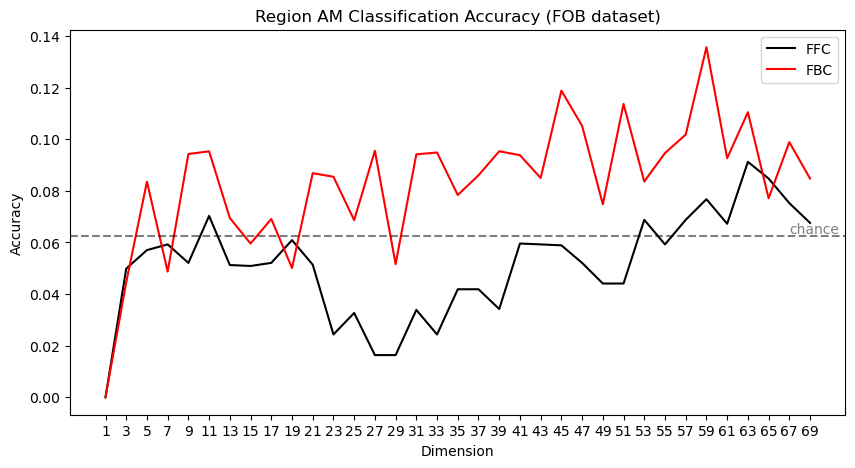

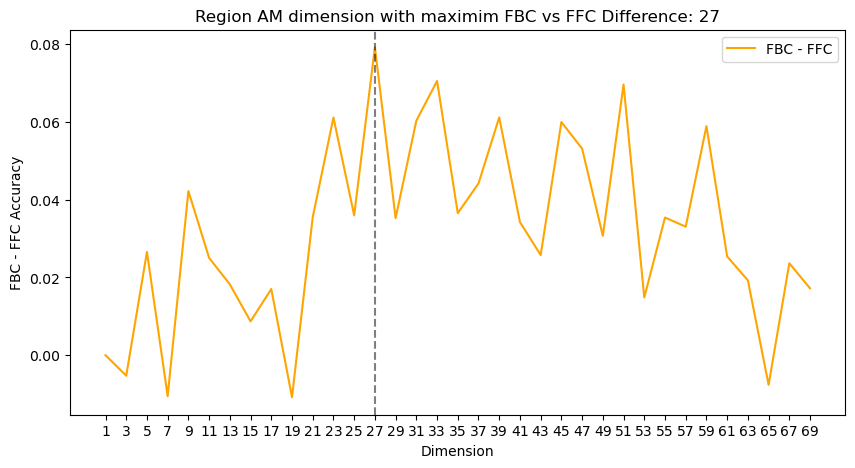

Max fold difference: 5.850297883128379


In [14]:
region = 'AM'

FFC_losses = 1 - all_losses['PCA'][region]
FBC_losses = 1 - all_losses['LQGCA'][region]
Diff_losses = FBC_losses - FFC_losses
max_dim_ind = np.argmax(Diff_losses)
max_diff_dim = dimensions[max_dim_ind]


plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, FFC_losses, label="FFC", color='black')
plt.plot(dimensions, FBC_losses, label="FBC", color='red')

plt.legend()
plt.title(f'Region {region} Classification Accuracy (FOB dataset)')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
#plt.axvline(x=max_diff_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.axhline(y=1/16, color=[0, 0, 0, 0.5], linestyle='--') 
plt.text(dimensions[-2], 1/16, 'chance', color=[0, 0, 0, 0.5], verticalalignment='bottom')
plt.show()

"""" 
plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, [np.sum(FFC_losses[0:idx]) for idx, loss in enumerate(FFC_losses) ], label="FFC")
plt.plot(dimensions, [np.sum(FBC_losses[0:idx]) for idx, loss in enumerate(FBC_losses) ], label="FBC")

plt.legend()
plt.title(f'Region {region} Classification Accuracy')
plt.xticks(dimensions[0:-2])
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.show()

"""

plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, Diff_losses, label="FBC - FFC", color='orange')

plt.legend()
plt.title(f'Region {region} dimension with maximim FBC vs FFC Difference: {max_diff_dim}')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('FBC - FFC Accuracy')
plt.axvline(x=max_diff_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.show()

print(f"Max fold difference: {FBC_losses[max_dim_ind]/FFC_losses[max_dim_ind]}")



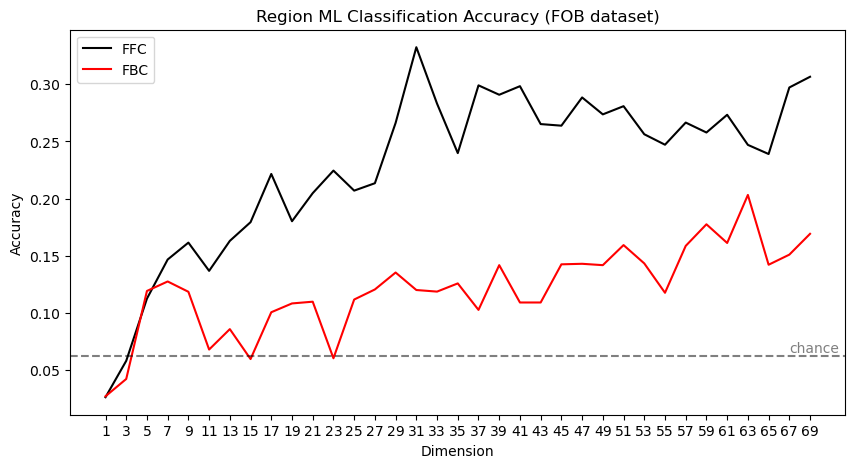

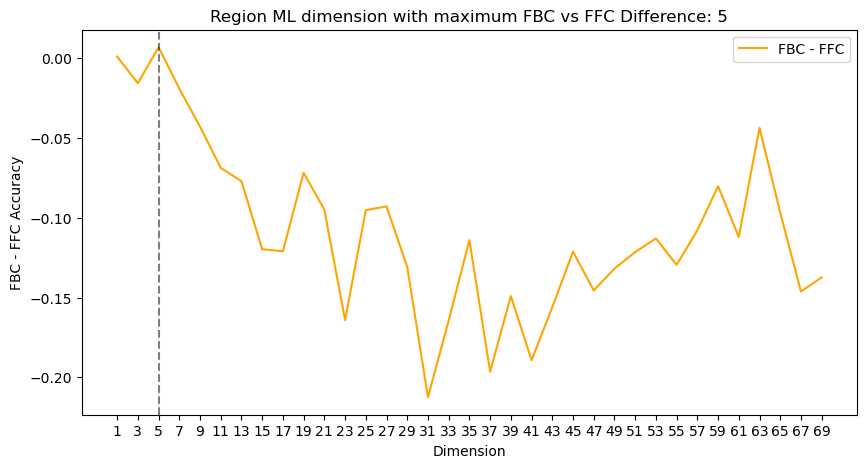

Max fold difference: 1.0596160571312874


In [15]:
region = 'ML'

FFC_losses = 1 - all_losses['PCA'][region]
FBC_losses = 1 - all_losses['LQGCA'][region]
Diff_losses = FBC_losses - FFC_losses
max_dim_ind = np.argmax(Diff_losses)
max_diff_dim = dimensions[max_dim_ind]


plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, FFC_losses, label="FFC", color='black')
plt.plot(dimensions, FBC_losses, label="FBC", color='red')

plt.legend()
plt.title(f'Region {region} Classification Accuracy (FOB dataset)')
plt.xticks(dimensions)
#plt.axvline(x=max_diff_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.axhline(y=1/16, color=[0, 0, 0, 0.5], linestyle='--') 
plt.text(dimensions[-2], 1/16, 'chance', color=[0, 0, 0, 0.5], verticalalignment='bottom')
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.show()


plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, Diff_losses, label="FBC - FFC", color='orange')

plt.legend()
plt.title(f'Region {region} dimension with maximum FBC vs FFC Difference: {max_diff_dim}')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('FBC - FFC Accuracy')
plt.axvline(x=max_diff_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.show()


print(f"Max fold difference: {FBC_losses[max_dim_ind]/FFC_losses[max_dim_ind]}")
